In [12]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from matplotlib.pyplot import matplotlib
from matplotlib.pyplot import *
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Exploratory Data Analysis 

In [13]:
df = pd.read_csv("train.csv",dtype = unicode)
#df = df.drop(columns = ["Id", "idhogar", "r4h3","r4m3","r4t3","dependency"])
df["v18q1"] = df["v18q1"].fillna(0)
df["rez_esc"] = df["rez_esc"].fillna(0)
def transfer_no(string):
    return 0
df.loc[df["edjefe"] == "no","edjefe"] = 0
df.loc[df["edjefa"] == "no","edjefa"] = 0
df.loc[df["edjefe"] == "yes","edjefe"] = 1
df.loc[df["edjefa"] == "yes","edjefa"] = 1

for col in df.columns.difference(['Id','idhogar',"dependency"]).values:
    df[col] = df[col].astype(float)
def vunlerable(x):
    return (x == 1 or x == 2 or x == 3)

vunlerable_mask = df["Target"].map(vunlerable)

df.loc[vunlerable_mask, "Target"] = 1
df.loc[~vunlerable_mask, "Target"] = 0

df = df.fillna(0)
df.index.name


Text(0.5,1,'% Population')

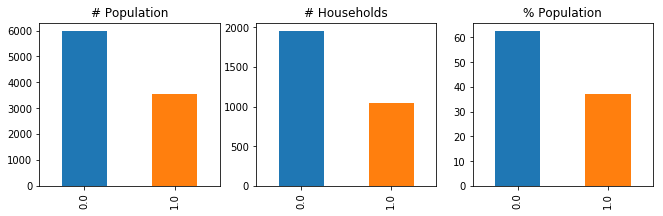

In [14]:
fig, (ax1, ax2,ax3) = subplots(nrows=1,
                           ncols=3,
                           sharex=True,
                           figsize=(11, 3))
df['Target'].value_counts().plot(ax=ax1,kind='bar')
ax1.set_title('# Population')
df[['Target','idhogar']].drop_duplicates().Target.value_counts().plot(ax=ax2,kind='bar')
ax2.set_title('# Households')
df['Target'].value_counts(normalize=True).rename('% of population').mul(100).plot(ax=ax3,kind='bar')
ax3.set_title('% Population')

Text(0.5,1,'# Households in Rural/Urban')

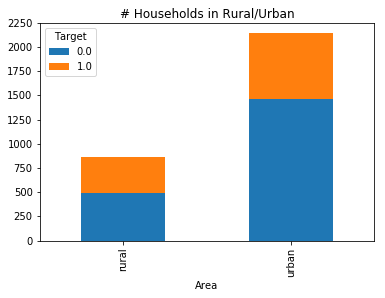

In [15]:
df.loc[df["lugar1"] == 1,"Region"] = "Central"
df.loc[df["lugar2"] == 1,"Region"] = "Chorotega"
df.loc[df["lugar3"] == 1,"Region"] = "Pacafafico central"
df.loc[df["lugar4"] == 1,"Region"] = "Brunca"
df.loc[df["lugar5"] == 1,"Region"] = "Huetar Atlafantica"
df.loc[df["lugar6"] == 1,"Region"] = "HuetarNorte"
df['Area'] = df['area1'].apply(lambda x: "urban" if x==1 else "rural")
df[['idhogar','Area','Target']].drop_duplicates().groupby(['Area'])['Target'].value_counts().unstack().plot(kind='bar',stacked=True)
title("# Households in Rural/Urban")

Text(0.5,1,'Rural scenario: By Region')

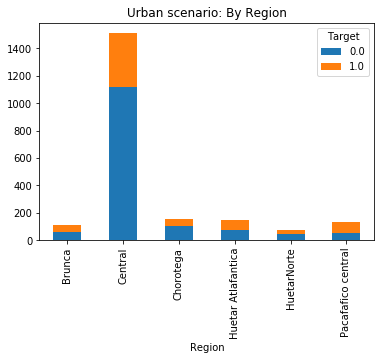

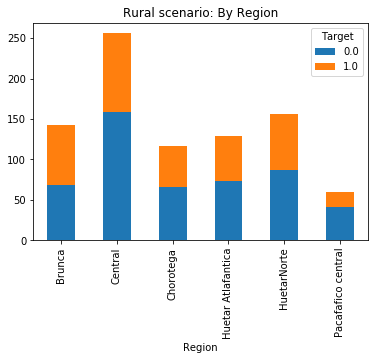

In [16]:
df_urban=df[df['Area']=='urban']
df4=df_urban[['idhogar','Target','Region']].drop_duplicates().groupby(['Region']).Target.value_counts()
df4.unstack().plot(kind='bar',stacked=True)
title("Urban scenario: By Region")
df_rural=df[df['Area']=='rural']
df5=df_rural[['idhogar','Target','Region']].drop_duplicates().groupby(['Region']).Target.value_counts()
df5.unstack().plot(kind='bar',stacked=True)
title("Rural scenario: By Region")

42.7 % in urban and 32.5 % in rural are vulnerable households eligible for financial assistance


Poor households are highest both in rural and urban areas of Central


In [17]:
DF_Region_Targ1=pd.DataFrame(df_rural[['idhogar','Target','Region']].drop_duplicates().groupby('Region').Target.value_counts(normalize=True).mul(100).unstack()[1].round(2).rename('%Rural_Targ1'))
DF_Region_Targ1['%Urban_Targ1']=pd.DataFrame(df_urban[['idhogar','Target','Region']].drop_duplicates().groupby('Region').Target.value_counts(normalize=True).mul(100).round(2).unstack()[1].rename('%Urban_Targ1'))
DF_Region_Targ1['%Targ1']=pd.DataFrame(df[['idhogar','Target','Region']].drop_duplicates().groupby('Region').Target.value_counts(normalize=True).mul(100).round(2).unstack()[1].rename('%Urban_Targ1'))
DF_Region_Targ1.style.background_gradient(cmap =sns.light_palette("orange", as_cmap=True))

,%Rural_Targ1,%Urban_Targ1,%Targ1
Region,,,
Brunca,52.45,41.28,47.62
Central,38.28,26.21,27.96
Chorotega,43.59,32.26,37.13
Huetar Atlafantica,43.41,48.99,46.4
HuetarNorte,44.23,37.18,41.88
Pacafafico central,31.67,59.12,50.76


Though absolute numbers are higher in Central, the proportion of poor households is much lower. More than 1 in 2 households are classified as poor households in rural Brunca and urban P_central. 


Text(0.5,1,'By House type')

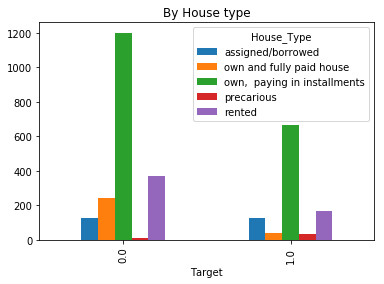

In [18]:
df.loc[df["tipovivi2"] == 1,"House_Type"] = "own and fully paid house"
df.loc[df["tipovivi1"] == 1,"House_Type"] = "own,  paying in installments"
df.loc[df["tipovivi3"] == 1,"House_Type"] = "rented"
df.loc[df["tipovivi4"] == 1,"House_Type"] = "precarious"
df.loc[df["tipovivi5"] == 1,"House_Type"] = "assigned/borrowed"
df[['idhogar','House_Type','Target']].drop_duplicates().groupby(['Target'])['House_Type'].value_counts().unstack().plot(kind='bar')
title("By House type")

# Potential Triggers of Poverty 

#Education

Text(0,0.5,'% of total population')

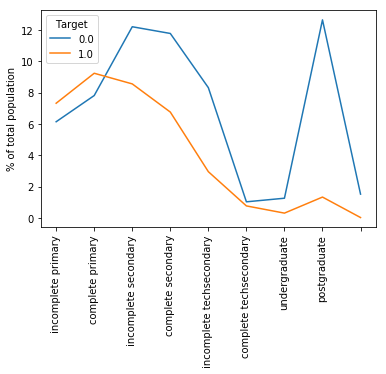

In [20]:
#df.rename(columns={'instlevel1':'no edu','instlevel2':'incomplete primary','instlevel3':'complete primary','instlevel4':'incomplete academic secondary level','instlevel5':'complete academic secondary level','instlevel6':'incomplete technical secondary level','instlevel7':'complete technical secondary level','instlevel8':'undergraduate and higher education','instlevel9':'postgraduate higher education'},inplace=True)
df_edu=df.groupby('Target')[[ 'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4','instlevel5', 'instlevel6', 'instlevel7', 'instlevel8','instlevel9']].sum().div(len(df)).mul(100).T
x = array(['no edu','incomplete primary','complete primary','incomplete secondary','complete secondary','incomplete techsecondary','complete techsecondary','undergraduate','postgraduate'])
df_edu.plot(rot=90,kind='line',fig=(2,15)).set_xticklabels(x)
ylabel('% of total population')


Education is negatively correlated with poverty and it does affect our standard of living！

#Overcrowding

Text(0,0.5,'Size of household')

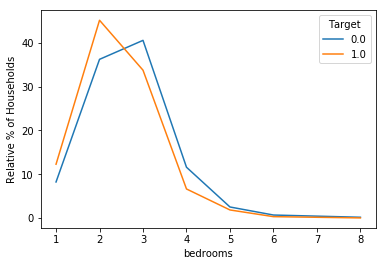

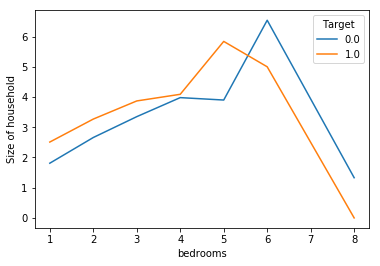

In [23]:
df.groupby(['Region','Target'])['tamhog','rooms','bedrooms'].mean().unstack().round(2)
df_xx=df[['idhogar','Target','tamhog','bedrooms']].drop_duplicates().groupby(['Target','bedrooms'])['tamhog'].agg('count').unstack().fillna(0)
df_xx.loc[1,]=(df_xx.loc[1,]/1042*1.0)*(100)
df_xx.loc[0,]=(df_xx.loc[0,]/1958*1.0)*(100)
df_xx.round(2).T.plot()
ylabel("Relative % of Households")
df_xx.round(2).T
df_xx=df[['idhogar','Target','tamhog','bedrooms']].drop_duplicates().groupby(['Target','bedrooms'])['tamhog'].agg('mean').unstack().fillna(0)
df_xx.round(2).T.plot()
ylabel("Size of household")


92% of vulnerable poor households and 85% of non-vulnerable households live in houses with less than three bedrooms.85% vs 92% . Not a big difference! But the average size of  poor households is also higher leading to overcrowding.


Text(0.5,0.98,'')

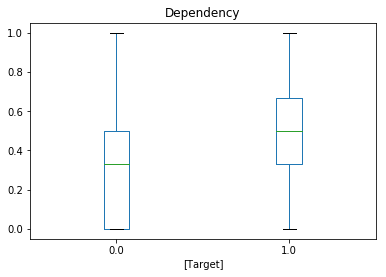

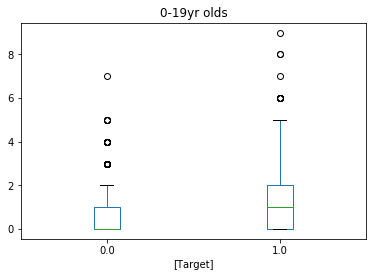

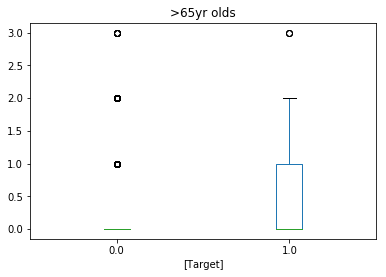

In [24]:
df1=df[['dependency','Target','hogar_adul','hogar_mayor','hogar_nin','tamviv','idhogar']].drop_duplicates()
df1['Dependency'] = (df1["hogar_mayor"]+df1['hogar_nin'])/df1["tamviv"]
boxplot = df1[["Dependency",'Target']].boxplot(by=['Target'],grid=False)
plt.suptitle("")
## 0-19 year old 
boxplot=df1[["hogar_nin",'Target','idhogar']].drop_duplicates()[["hogar_nin",'Target']]
boxplot.rename(columns={'hogar_nin':"0-19yr olds"},inplace=True)
boxplot.boxplot(by=['Target'],grid=False,return_type='both')
plt.suptitle("")
boxplot=df1[["hogar_mayor",'Target','idhogar']].drop_duplicates()[["hogar_mayor",'Target']]
boxplot.rename(columns={'hogar_mayor':">65yr olds"},inplace=True)
boxplot.boxplot(by=['Target'],grid=False,return_type='both')
plt.suptitle("")

Text(0.5,1,'Person_Type')

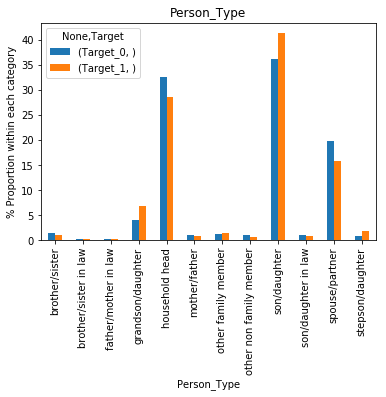

In [25]:
df.loc[df["parentesco1"] == 1,"Person_Type"] = "household head"
df.loc[df["parentesco2"] == 1,"Person_Type"] = "spouse/partner"
df.loc[df["parentesco3"] == 1,"Person_Type"] = "son/daughter"
df.loc[df["parentesco4"] == 1,"Person_Type"] = "stepson/daughter"
df.loc[df["parentesco5"] == 1,"Person_Type"] = "son/daughter in law"
df.loc[df["parentesco6"] == 1,"Person_Type"] = "grandson/daughter"
df.loc[df["parentesco7"] == 1,"Person_Type"] = "mother/father"
df.loc[df["parentesco8"] == 1,"Person_Type"] = "father/mother in law"
df.loc[df["parentesco9"] == 1,"Person_Type"] = "brother/sister"
df.loc[df["parentesco10"] == 1,"Person_Type"] = "brother/sister in law"
df.loc[df["parentesco11"] == 1,"Person_Type"] = "other family member"
df.loc[df["parentesco12"] == 1,"Person_Type"] = "other non family member"
df_xyz1=df[['Target','idhogar','Person_Type']].groupby(['Person_Type','Target']).count().unstack()
sum0=df_xyz1.sum()[0]
sum1=df_xyz1.sum()[1]
df_xyz1['Target_0']=(df_xyz1['idhogar'][0]/sum0)*(100)
df_xyz1['Target_1']=(df_xyz1['idhogar'][1]/sum1)*(100)

df_xyz1[['Target_0','Target_1']].round(2).plot(kind='bar')
ylabel("% Proportion within each category")
title("Person_Type")

Dependents proportion  (son/daughter, grandson/daughter, stepson/daughter) in poor households is higher.

In poor households we see that there are more people other than just the mother, father and children. 



Text(0,0.5,'# Households')

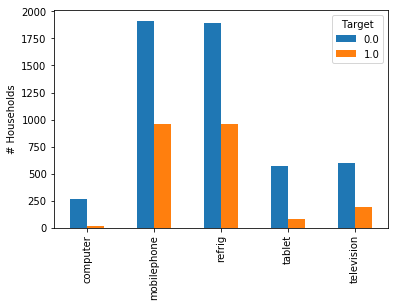

In [26]:
df5=df[['Target','idhogar','computer','television','mobilephone','refrig','v18q']].drop_duplicates()
df5.rename(columns={'v18q':'tablet'}, inplace=True)
df5.set_index('idhogar',inplace=True)
from pandas import *
pivot_table(df5,values=['computer','refrig','television','mobilephone','tablet'],columns=['Target'],aggfunc='sum').plot(kind='bar',fig=(6,10),rot=90)
ylabel("# Households")


Majority of Costa Rican households (both poor and non-poor ) have at least one mobile phone.

Social programs can better reach people in Costa Rica through text or call than television marketing. 


In [27]:
df = df.drop(columns = ["Id","dependency"])
# Summarising the attributes on a household level
age = df.groupby(["idhogar"])[["age"]].mean()
school = df.groupby(["idhogar"])[["escolari"]].mean()
behind_school = df.groupby(["idhogar"])[["rez_esc"]].mean()
qmobile = df.groupby(["idhogar"])[["qmobilephone"]].mean()
education = df.groupby(["idhogar"])\
["instlevel1","instlevel2","instlevel3","instlevel4","instlevel5","instlevel6","instlevel7","instlevel8","instlevel9"].sum()
new_df = df.drop_duplicates(["idhogar"])
new_df = new_df.set_index(["idhogar"])
#Removing individual level columns 
new_df = new_df.drop(columns=['instlevel1','v18q',\
       'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',\
       'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9', 'SQBage',\
       'SQBhogar_total', 'SQBhogar_nin', 'SQBovercrowding',\
       'SQBmeaned', 'agesq','dis', 'male', 'female', 'estadocivil1', 'estadocivil2',\
       'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6',\
       'estadocivil7', 'parentesco1', 'parentesco2', 'parentesco3',\
       'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',\
       'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11',\
       'parentesco12','r4h3','r4m3','r4t1',"age",
       'r4t2', 'r4t3','qmobilephone','SQBdependency',"rez_esc"])
#'Labor' = # of independent people (Size of household-(<19yrs old + >65+ yrs old))
new_df["Labor"] = (new_df["hogar_total"] - new_df["hogar_mayor"] - new_df["hogar_nin"])
new_df["supportRate"] = new_df["Labor"]/(new_df["hogar_total"])
# Joining the summairsed attributes with already existing household level attributes 
df_family = new_df.merge(age, left_index=True, right_index=True).\
    merge(behind_school, left_index=True, right_index=True).\
    merge(qmobile, left_index=True, right_index=True).\
    merge(education, left_index=True, right_index=True)
Target = df_family["Target"].copy()
df_family = df_family.drop(columns=["Target"])
df_family["Target"] = Target
df_EDA = df_family.copy()
df_EDA.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q1,r4h1,r4h2,r4m1,...,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,Target
idhogar,,,,,,,,,,,,,,,,,,,,,
21eb7fcc1,190000.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0e5d7a658,135000.0,0.0,4.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2c7317ea8,0.0,0.0,8.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2b58d945f,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,...,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
d6dae86b7,130000.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


Text(0.5,0,'male head schooling years')

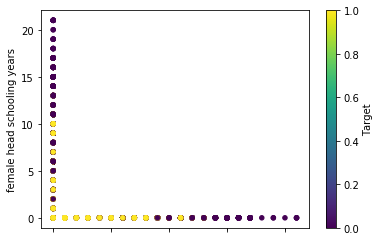

In [33]:
df_EDA.plot.scatter(x='edjefa',
...                       y='edjefe',
...                       c='Target',
...                       colormap='viridis')
ylabel("female head schooling years")
xlabel("male head schooling years")

Among households in poverty, the male and female head of the family have relatively lower schooling years.


# Modeling: Classification of households

1. Directly calculate the poverty probability of households
2. Compute a weighted average poverty probability of the members for each household

Models used : Logistic Regression, Naive Bayes, Random Forest


# Modelling on household level data

In [36]:
#Logistic Regression

In [42]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_family, test_size = 0.2)
#train.columns.values
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
formula = "Target ~ 0 + v2a1 + hacdor + rooms + hacapo + v14a + refrig + v18q1 + r4h1 + \
r4h2 + r4m1 + r4m2 + tamhog + tamviv + escolari + rez_esc + hhsize + paredblolad +\
paredzocalo + paredpreb + pareddes + paredmad + paredzinc + paredfibras + paredother \
+ pisomoscer + pisocemento + pisoother + pisonatur + pisonotiene + pisomadera + techozinc + \
techoentrepiso + techocane + techootro + cielorazo + abastaguadentro + abastaguafuera + abastaguano + \
public + planpri + noelec + coopele + sanitario2 + sanitario3 + sanitario5 + sanitario6 + \
energcocinar2 + energcocinar3 + energcocinar4 + elimbasu2 + elimbasu3 + elimbasu4 + \
elimbasu5 + elimbasu6 + epared2 + epared3 + etecho2 + etecho3 + eviv2 + eviv3 + hogar_nin +\
hogar_adul + hogar_mayor + hogar_total + edjefe + edjefa + meaneduc + tipovivi1 + tipovivi2 + tipovivi3 + tipovivi4 + \
tipovivi5 + computer + television + mobilephone + lugar2 + lugar3 + lugar4 + lugar5 + lugar6 + area1 + area2 +\
SQBescolari + SQBedjefe + Labor + supportRate + age + qmobilephone + instlevel1 + instlevel2 + instlevel3 + \
instlevel4 + instlevel5 + instlevel6 + instlevel7 + instlevel8 + instlevel9 + bedrooms + overcrowding"
train_Y, train_X = dmatrices(formula, train, return_type='dataframe')
train_X.head()
train_y = train_Y['Target'].values
model1 = LogisticRegression()
result = model1.fit(train_X, train_y)
from sklearn import metrics
prediction_train = model1.predict(train_X)
print "Training set accuracy - Logistic Regression (Household level) " ,metrics.accuracy_score(train_y, prediction_train)

Training set accuracy - Logistic Regression (Household level)  0.7179916317991631


0.7359840730118867


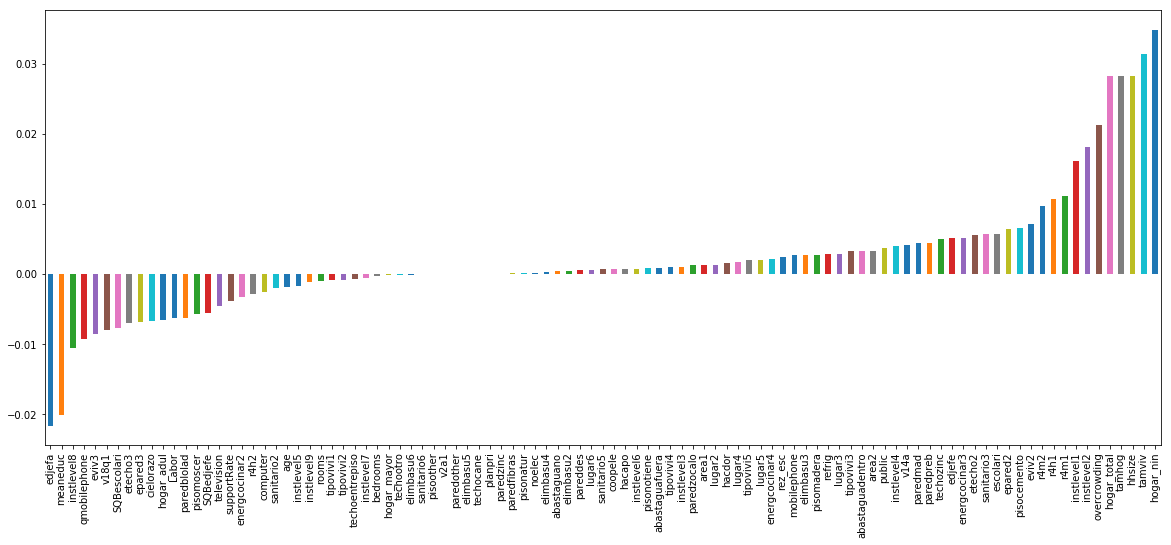

In [53]:
# Create the folds in the training data
kfold = StratifiedKFold(n_splits = 5, shuffle=True)
model1_k = LogisticRegression()
scores = cross_val_score(model1_k, train_X, train_y, cv=kfold)
print scores.mean()
weights = pd.Series(model1.coef_[0],
                 index = train_X.columns.values)
pylab.rcParams['figure.figsize'] = (20, 8)
#weights.sort_values()[:10].plot(kind = "bar")
weights.sort_values()[:].plot(kind = "bar")
show()
#weights.sort_values()

In [55]:
# Naive Bayes

In [54]:
train_family_category = df_family.copy()
train_family_category["age_cut"] = pd.qcut(df['age'], 5)
train_family_category["meaneduc_cut"] = pd.qcut(df['meaneduc'], 5)
train_family_category["overcrowding_cut"] = pd.qcut(train_family_category['overcrowding'], 3)
categorical_columns = ['hacdor', 'rooms', 'hacapo', 'v14a', 'refrig', 'age_cut','meaneduc_cut',\
                       'r4h1', 'r4h2', 'r4m1', 'r4m2',  'tamhog','tamviv', 'escolari', 'rez_esc', 'hhsize',  'hogar_nin', 'hogar_adul']
df_dummies = pd.get_dummies(train_family_category[categorical_columns],
                            prefix=categorical_columns,
                            columns=categorical_columns)
dummy_column_names = df_dummies.columns.values 
df_dummies.head()

,hacdor_0.0,hacdor_1.0,rooms_1.0,rooms_2.0,rooms_3.0,rooms_4.0,rooms_5.0,rooms_6.0,rooms_7.0,rooms_8.0,...,hogar_adul_0.0,hogar_adul_1.0,hogar_adul_2.0,hogar_adul_3.0,hogar_adul_4.0,hogar_adul_5.0,hogar_adul_6.0,hogar_adul_7.0,hogar_adul_8.0,hogar_adul_9.0
idhogar,,,,,,,,,,,,,,,,,,,,,
21eb7fcc1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
0e5d7a658,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2c7317ea8,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2b58d945f,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
d6dae86b7,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [244]:
train2 = pd.concat([train_family_category, df_dummies], axis=1)
formula2 = 'Target ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
train2_Y, train2_X = dmatrices(formula2, train2, return_type='dataframe')
train2_y = train2_Y['Target'].values

from sklearn import naive_bayes
model2 = naive_bayes.MultinomialNB()
model2.fit(train2_X, train2_y)

from sklearn import metrics

prediction_train = model2.predict(train2_X)
print "Training set accuracy " ,metrics.accuracy_score(train2_y, prediction_train)
kfold = StratifiedKFold(n_splits = 5, shuffle=True)
model2_k = naive_bayes.MultinomialNB()
scores = cross_val_score(model2_k, train2_X, train2_y, cv=kfold)
print "Training set accuracy" ,scores.mean()

Training set accuracy  0.7004685408299867
Training set accuracy 0.6917903077372001


# Modelling on Individual level data 

In [245]:
df_individual = df.copy()
parentesco = df[["parentesco1","parentesco2","parentesco3","parentesco4",\
                "parentesco5","parentesco6","parentesco7","parentesco8",\
                "parentesco9","parentesco10","parentesco11","parentesco12"]].stack()
parentesco = pd.Series(pd.Categorical(parentesco[parentesco!=0].index.get_level_values(1)))
df_individual["parentesco"] = parentesco
def in_train(x):
    return x in train.index
individual_train = df_individual[df_individual["idhogar"].map(in_train)]
def in_test(x):
    return x in test.index
individual_train = df_individual[df_individual["idhogar"].map(in_train)]
individual_test = df_individual[df_individual["idhogar"].map(in_test)]

In [246]:
formula3 = "Target ~ 0 + v2a1 + hacdor + rooms + hacapo + v14a + refrig + v18q1 + r4h1 + \
            r4h2 + r4m1 + r4m2 + tamhog + tamviv + escolari + rez_esc + hhsize + paredblolad +\
            paredzocalo + paredpreb + pareddes + paredmad + paredzinc + paredfibras + paredother \
            + pisomoscer + pisocemento + pisoother + pisonatur + pisonotiene + pisomadera + techozinc + \
            techoentrepiso + techocane + techootro + cielorazo + abastaguadentro + abastaguafuera + abastaguano + \
            public + planpri + noelec + coopele + sanitario2 + sanitario3 + sanitario5 + sanitario6 + \
            energcocinar2 + energcocinar3 + energcocinar4 + elimbasu2 + elimbasu3 + elimbasu4 + \
            elimbasu5 + elimbasu6 + epared2 + epared3 + etecho2 + etecho3 + eviv2 + eviv3 + hogar_nin +\
            hogar_adul + hogar_mayor + hogar_total + edjefe + edjefa + meaneduc + tipovivi1 + tipovivi2 + tipovivi3 + tipovivi4 + \
            tipovivi5 + computer + television + mobilephone + lugar2 + lugar3 + lugar4 + lugar5 + lugar6 + area1 + area2 +\
            SQBescolari + SQBedjefe + age + qmobilephone + instlevel2 + instlevel3 + \
            instlevel4 + instlevel5 + instlevel6 + instlevel7 + instlevel8 + instlevel9 + bedrooms + overcrowding"

individual_train_Y, individual_train_X = dmatrices(formula3, individual_train, return_type='dataframe')
individual_train_y = individual_train_Y['Target'].values
individual_test_Y, individual_test_X = dmatrices(formula3, individual_test, return_type='dataframe')
individual_test_y = individual_test_Y['Target'].values

In [87]:
# Logistic Regression

In [121]:
model3 = LogisticRegression()
result3 = model3.fit(individual_train_X, individual_train_y)
kfold = StratifiedKFold(n_splits = 20, shuffle=True)
#model3_k = LogisticRegression()
individual_prediction_train = model3.predict(individual_train_X)

print "Training set accuracy ", metrics.accuracy_score(individual_train_y, individual_prediction_train)


Training set accuracy  0.7239937271301621


Assigning higher weightage to the poverty probablity of the head and lower weightages to the rest of the household 

In [122]:
weight = [5,1,1,1,1,1,1,1,1,1,1,1]
individual_prediction_train = model3.predict(individual_train_X)

def get_prob(arr):
    result = []
    for i in range(len(arr)):
        result.append(arr[i][1])
    return pd.Series(result)
prob_series  = get_prob(model3.predict_proba(individual_train_X))
individual_train["prob"]= prob_series.values

#Individual poverty probabilities of each household 

In [123]:
family_tab = individual_train[["idhogar","parentesco","prob"]]
family_tab = family_tab.groupby(["idhogar","parentesco"])["prob"].mean()
family_tab = family_tab.unstack("parentesco")
family_tab = family_tab.fillna(0)
family_tab = family_tab.rename(columns = {"parentesco1":"household head",\
                                     "parentesco2":"spouse/partner",\
                                     "parentesco3":"son/doughter"\
                                     ,"parentesco4":"stepson/doughter"\
                                     ,"parentesco5":"son/doughter in law",\
                                     "parentesco6":"grandson/doughter",\
                                     "parentesco7":"mother/father",\
                                     "parentesco8":"father/mother in law",\
                                     "parentesco9":"brother/sister",\
                                     "parentesco10":"brother/sister in law",\
                                     "parentesco11":"other family member",\
                                     "parentesco12":"other non family member",\
                                     })

family_tab.head() 

parentesco,household head,brother/sister in law,other family member,other non family member,spouse/partner,son/doughter,stepson/doughter,son/doughter in law,grandson/doughter,mother/father,father/mother in law,brother/sister
idhogar,,,,,,,,,,,,
003123ec2,0.544115,0.0,0.0,0.0,0.527527,0.601052,0.0,0.0,0.00000,0.0,0.0,0.0
004616164,0.500446,0.0,0.0,0.0,0.000000,0.369808,0.0,0.0,0.00000,0.0,0.0,0.0
004983866,0.317374,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.37013,0.0,0.0,0.0
006031de3,0.040510,0.0,0.0,0.0,0.033920,0.143536,0.0,0.0,0.00000,0.0,0.0,0.0
006555fe2,0.443881,0.0,0.0,0.0,0.302853,0.279091,0.0,0.0,0.00000,0.0,0.0,0.0


In [124]:
family_tab = family_tab.fillna(0)
#Assigning weights
def weight_vote(weights):
    index_list = family_tab.index.values
    column_list =family_tab.columns.values
    result = []
    for i in range(len(index_list)):
        index = index_list[i]
        total = 0
        score = 0
        for j in range(len(column_list)):
            column = column_list[j]
            if family_tab.loc[index,column] != 0:
                a = family_tab.loc[index,column] * weights[j]
                b = weights[j]
                total += b
                score += a
        result.append(score/total)
    return pd.Series(result)
pre = weight_vote(weight)
train["pre"] = pre.values
train["pre"] = (train["pre"] > 0.5)
print "Accuracy on individual level - Logistic Regression" , 1.0 * sum(train["pre"] == train["Target"]) / len(train)

Accuracy on individual level - Logistic Regression 0.6041841004184101


In [137]:
# Random forest on household - level"

In [280]:
from sklearn.ensemble import RandomForestClassifier
formula4 = "Target ~ 0 + v2a1 + hacdor + rooms + hacapo + v14a + refrig + v18q1 + r4h1 + \
r4h2 + r4m1 + r4m2 + tamhog + tamviv + escolari + rez_esc + hhsize + paredblolad +\
paredzocalo + paredpreb + pareddes + paredmad + paredzinc + paredfibras + paredother \
+ pisomoscer + pisocemento + pisoother + pisonatur + pisonotiene + pisomadera + techozinc + \
techoentrepiso + techocane + techootro + cielorazo + abastaguadentro + abastaguafuera + abastaguano + \
public + planpri + noelec + coopele + sanitario2 + sanitario3 + sanitario5 + sanitario6 + \
energcocinar2 + energcocinar3 + energcocinar4 + elimbasu2 + elimbasu3 + elimbasu4 + \
elimbasu5 + elimbasu6 + epared2 + epared3 + etecho2 + etecho3 + eviv2 + eviv3 + hogar_nin +\
hogar_adul + hogar_mayor + hogar_total + edjefe + edjefa + meaneduc + tipovivi1 + tipovivi2 + tipovivi3 + tipovivi4 + \
tipovivi5 + computer + television + mobilephone + lugar2 + lugar3 + lugar4 + lugar5 + lugar6 + area1 + area2 +\
SQBedjefe + Labor + supportRate + age + qmobilephone + instlevel1 + instlevel2 + instlevel3 + \
instlevel4 + instlevel5 + instlevel6 + instlevel7 + instlevel8 + instlevel9 + bedrooms + overcrowding"
df_family_Y, df_family_X = dmatrices(formula4, df_family, return_type='dataframe')
train_Y, train_X = dmatrices(formula4, train, return_type='dataframe')
test_Y, test_X = dmatrices(formula4, test, return_type='dataframe')
train_y = train_Y['Target'].values
test_y = test_Y['Target'].values
from sklearn import metrics

# Create the folds in the training data
best_depth = 0
best_features = 0
highest_score = 0

model4 = RandomForestClassifier(max_depth= 10, max_features = 20, n_estimators = 50)
model4.fit(train_X, train_y)

from sklearn import metrics

prediction_train = model4.predict(train_X)
prediction_test = model4.predict(test_X)
print "Trainig accuracy - Random Forest ", metrics.accuracy_score(train_y, prediction_train)
print "Testing accuracy - Random Forest ", metrics.accuracy_score(test_y, prediction_test)
kfold = StratifiedKFold(n_splits = 5, shuffle=True)
scores = cross_val_score(model4, df_family_X, df_family_Y, cv = kfold)
print "K-fold - Random Forest", scores.mean()

Trainig accuracy - Random Forest  0.9468619246861925
Testing accuracy - Random Forest  0.7792642140468228
K-fold - Random Forest 0.7643779039752194


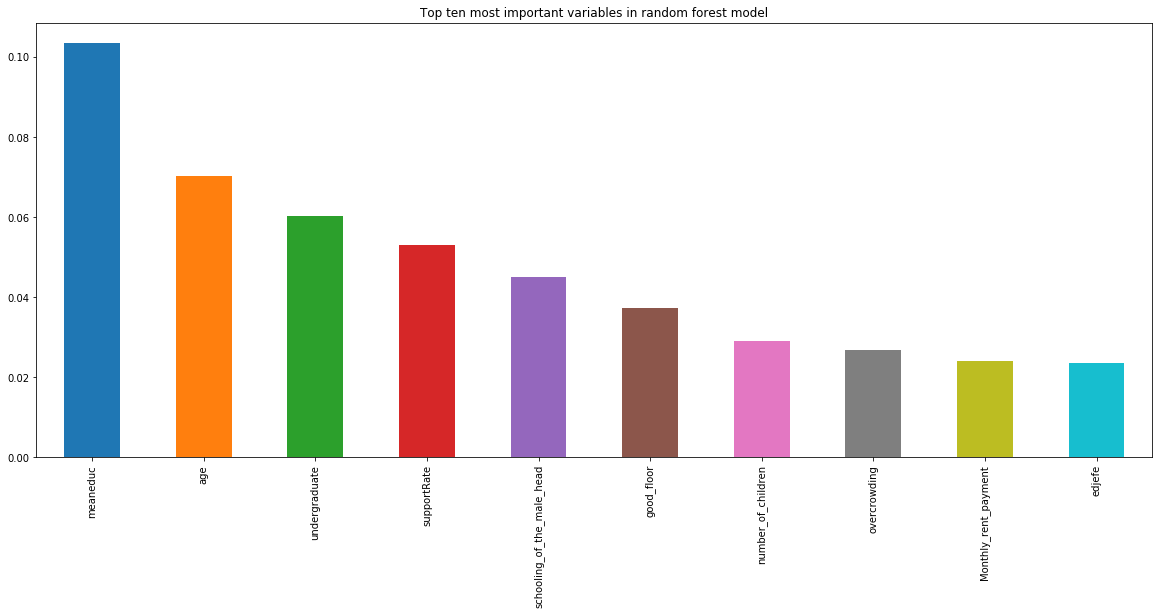

In [281]:
weights2 = pd.DataFrame(model4.feature_importances_,
                 index = train_X.columns.values)
weights2_1=weights2.T
#square of schooling of the male head
weights2_1.rename(columns = {"escolari":"schooling_of_the_male_head","instlevel8":"undergraduate", "hogar_nin":"number_of_children", "eviv3":"good_floor","v2a1":"Monthly_rent_payment"},inplace=True)
weights2_1=weights2_1.T
weights2_1=(Series(weights2_1[0]))

weights2_1.sort_values(ascending=False)[0:10].plot(kind = "bar", title = "Top ten most important variables in random forest model")
weights2_1.sort_values(ascending=False)[:10]
weights2 = pd.Series(model4.feature_importances_,
                 index = train_X.columns.values)

In [216]:
# Random forest on individual - level"

In [282]:
from sklearn.ensemble import RandomForestClassifier
formula5 = 'Target ~ 0 + {}'.format(' + '.join(["{}".format(x) for x in weights2.sort_values(ascending=False).index[0:30]]))
formula5

'Target ~ 0 + meaneduc + age + instlevel8 + supportRate + escolari + eviv3 + hogar_nin + overcrowding + v2a1 + edjefe + instlevel2 + qmobilephone + SQBedjefe + paredblolad + epared3 + instlevel1 + v18q1 + rooms + cielorazo + edjefa + r4h2 + etecho3 + rez_esc + r4m2 + instlevel3 + bedrooms + hogar_adul + instlevel4 + Labor + r4m1'

In [283]:
train_Y, train_X = dmatrices(formula5, train, return_type='dataframe')
train_y = train_Y['Target'].values




0.6041841004184101


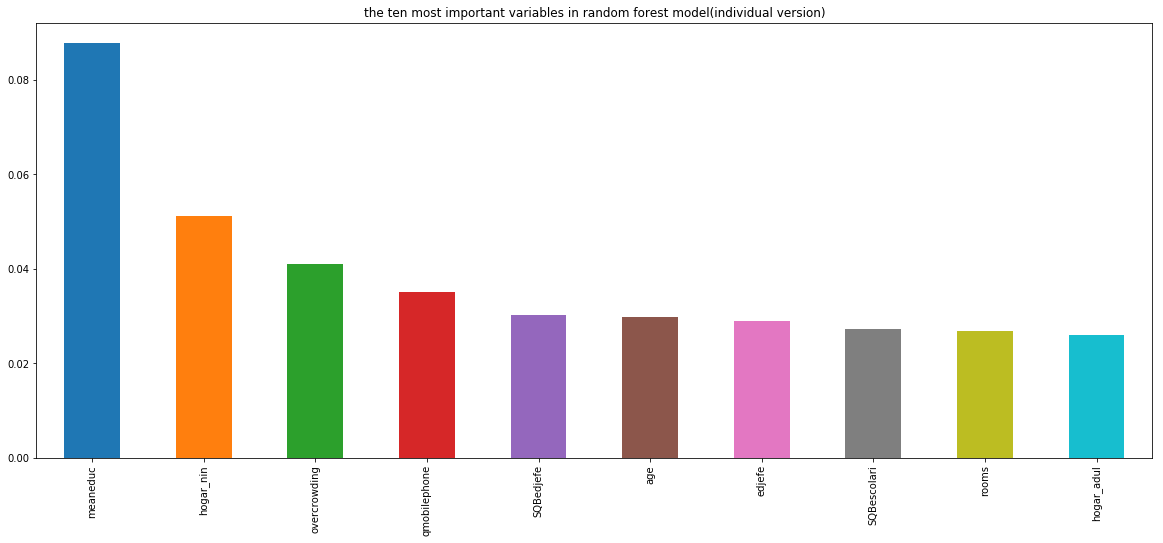

In [293]:
formula6 = "Target ~ 0 + v2a1 + hacdor + rooms + hacapo + v14a + refrig + v18q1 + r4h1 + \
            r4h2 + r4m1 + r4m2 + tamhog + tamviv + escolari + rez_esc + hhsize + paredblolad +\
            paredzocalo + paredpreb + pareddes + paredmad + paredzinc + paredfibras + paredother \
            + pisomoscer + pisocemento + pisoother + pisonatur + pisonotiene + pisomadera + techozinc + \
            techoentrepiso + techocane + techootro + cielorazo + abastaguadentro + abastaguafuera + abastaguano + \
            public + planpri + noelec + coopele + sanitario2 + sanitario3 + sanitario5 + sanitario6 + \
            energcocinar2 + energcocinar3 + energcocinar4 + elimbasu2 + elimbasu3 + elimbasu4 + \
            elimbasu5 + elimbasu6 + epared2 + epared3 + etecho2 + etecho3 + eviv2 + eviv3 + hogar_nin +\
            hogar_adul + hogar_mayor + hogar_total + edjefe + edjefa + meaneduc + tipovivi1 + tipovivi2 + tipovivi3 + tipovivi4 + \
            tipovivi5 + computer + television + mobilephone + lugar2 + lugar3 + lugar4 + lugar5 + lugar6 + area1 + area2 +\
            SQBescolari + SQBedjefe + age + qmobilephone + instlevel2 + instlevel3 + \
            instlevel4 + instlevel5 + instlevel6 + instlevel7 + instlevel8 + instlevel9 + bedrooms + overcrowding"

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics
individual_train_Y, individual_train_X = dmatrices(formula6, individual_train, return_type='dataframe')
individual_train_y = individual_train_Y['Target'].values



model6 = RandomForestClassifier(max_depth = 65, max_features = 10, n_estimators = 100)
result6 = model6.fit(individual_train_X, individual_train_y)

kfold = StratifiedKFold(n_splits = 20, shuffle=True)

model3_k = RandomForestClassifier(max_depth = 65, max_features = 10, n_estimators = 100)

individual_prediction_train = model6.predict(individual_train_X)

accuracy_score= metrics.accuracy_score(individual_train_y, individual_prediction_train)


weight = [5,1,1,1,1,1,1,1,1,1,1,1]

individual_prediction_train = model6.predict(individual_train_X)




prob_series2  = get_prob(model6.predict_proba(individual_train_X))




individual_train["prob"]= prob_series.values


family_tab = individual_train[["idhogar","parentesco","prob"]]
family_tab = family_tab.groupby(["idhogar","parentesco"])["prob"].mean()
family_tab = family_tab.unstack("parentesco")


def get_prob(arr):
    result = []
    for i in range(len(arr)):
        result.append(arr[i][1])
    return pd.Series(result)


prob_series  = get_prob(model3.predict_proba(individual_train_X))




individual_train["prob"]= prob_series.values


family_tab = individual_train[["idhogar","parentesco","prob"]]
family_tab = family_tab.groupby(["idhogar","parentesco"])["prob"].mean()
family_tab = family_tab.unstack("parentesco")



family_tab = family_tab.fillna(0)

def weight_vote2(weights):
    index_list = family_tab.index.values
    column_list =family_tab.columns.values
    result = []
    for i in range(len(index_list)):
        index = index_list[i]
        total = 0
        score = 0
        for j in range(len(column_list)):
            column = column_list[j]
            if family_tab.loc[index,column] != 0:
                
                a = family_tab.loc[index,column] * weights[j]
                b = weights[j]
                total += b
                score += a
        result.append(score/total)
    return pd.Series(result)

    
pre2 = weight_vote2(weight)
train["pre2"] = pre2.values
train["pre2"] = (train["pre2"] > 0.5)
print 1.0 * sum(train["pre2"] == train["Target"]) / len(train)


weights3 = pd.Series(model6.feature_importances_,
                 index = individual_train_X.columns.values)
weights3.sort_values(ascending=False)[0:10].plot(kind = "bar", title = "the ten most important variables in random forest model(individual version)")